<h1> CLASSIFICATORE NAIVE BAYES: RATING</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [3]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

<h2>Caricamento train set e test set</h2>

In [4]:
df_tra= pd.read_csv('df_train.csv',  skipinitialspace=True)

In [5]:
df_tes= pd.read_csv('df_test.csv', skipinitialspace=True)

In [6]:
# Mappatura inversa
rating_mapping_inverse = {
    1: '(0, 1]',
    2: '(1, 2]',
    3: '(2, 3]',
    4: '(3, 4]',
    5: '(4, 5]',
    6: '(5, 6]',
    7: '(6, 7]',
    8: '(7, 8]',
    9: '(8, 9]',
    10: '(9, 10]'
}

# Applica la mappatura inversa alla colonna 'rating' di df_train
df_tra['rating'] = df_tra['rating'].map(rating_mapping_inverse)

# Visualizzare i risultati
print(df_tra['rating'].head())


0    (7, 8]
1    (5, 6]
2    (5, 6]
3    (5, 6]
4    (7, 8]
Name: rating, dtype: object


In [7]:
df_tes['canHaveEpisodes'] = df_tes['canHaveEpisodes'].astype(int)

In [8]:
# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df_tes['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df_tes['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country')  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(df_tes['titleType'], prefix='titleType')

# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df_tes, df_genres, df_country_encoded, df_title_type], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato
df_tes = df_encoded.copy()
df_tes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Columns: 166 entries, rating to titleType_videoGame
dtypes: bool(10), float64(2), int64(153), object(1)
memory usage: 6.6+ MB


In [9]:
# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df_tra['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df_tra['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country')  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()

# 3. One-Hot Encoding della variabile 'titleType'
df_title_type = pd.get_dummies(df_tra['titleType'], prefix='titleType')

# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df_tra, df_genres, df_country_encoded, df_title_type], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin', 'titleType'])

# Visualizza i primi 5 record del dataframe trasformato
df_tra = df_encoded.copy()
df_tra.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16416 entries, 0 to 16415
Columns: 205 entries, rating to titleType_10
dtypes: bool(10), int64(194), object(1)
memory usage: 24.6+ MB


In [10]:
no_coun_train=0
for c in df_tra.columns:
    #print(c)
    no_coun_train+=1
no_coun_test=0
for c in df_tes.columns:
    #print(c)
    no_coun_test+=1
print(no_coun_test, no_coun_train)

166 205


In [11]:
df_tes = df_tes.reindex(columns=df_tra.columns, fill_value=0)
print("clean_train shape:", df_tra.shape)
print("clean_test shape:", df_tes.shape)

clean_train shape: (16416, 205)
clean_test shape: (5460, 205)


In [12]:
df_train = df_tra.copy()
df_test = df_tes.copy()

<h1> VALUTAZIONE SU TEST SET </h1>

In [13]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.preprocessing import StandardScaler

<h2> GAUSSIAN NB</h2>

In [14]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# 1. Selezioniamo le variabili numeriche
non_cat_columns = [
    "startYear", "runtimeMinutes", "awardWins", "totalImages", "totalVideos", 
    "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", 
    "userReviewsTotal", "ratingCount", "numRegions"
]

# 2. Preprocessing dei dati di addestramento (df_train)
X_train_noncat = df_train[non_cat_columns].values  # Usa df_train

# Codifica del target 'titleType' (etichetta categorica)
label_encoder = LabelEncoder()
y_train_noncat = label_encoder.fit_transform(df_train['rating'])  # 'titleType' è il target ora

# 3. Creazione del modello Naive Bayes
nbg = GaussianNB()
nbg.fit(X_train_noncat, y_train_noncat)

# 4. **Test sul Test Set (df_test)**

# Selezioniamo le stesse feature numeriche per il test set
X_test_gauss = df_test[non_cat_columns].values  # Usa df_test

# Codifica anche le etichette del test set
y_test_gauss = label_encoder.transform(df_test['rating'])  # Codifica 'titleType' come nel training

# Fare predizioni sul test set
y_pred_test = nbg.predict(X_test_gauss)

# 5. Report di classificazione sul Test Set
print("Classification Report sul Test Set:")
print(classification_report(y_test_gauss, y_pred_test))

# Calcolare ROC AUC (multi-class) sul test set
print("ROC AUC score sul Test Set:", roc_auc_score(y_test_gauss, nbg.predict_proba(X_test_gauss), multi_class="ovr", average="micro"))


Classification Report sul Test Set:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           1       0.00      0.00      0.00        19
           2       0.01      0.48      0.02        52
           3       0.00      0.00      0.00       155
           4       0.09      0.07      0.08       383
           5       0.23      0.07      0.10       929
           6       0.31      0.04      0.06      1516
           7       0.34      0.02      0.03      1603
           8       0.12      0.01      0.01       686
           9       0.09      0.08      0.08       116

    accuracy                           0.04      5460
   macro avg       0.12      0.17      0.04      5460
weighted avg       0.25      0.04      0.05      5460

ROC AUC score sul Test Set: 0.48373801361438723


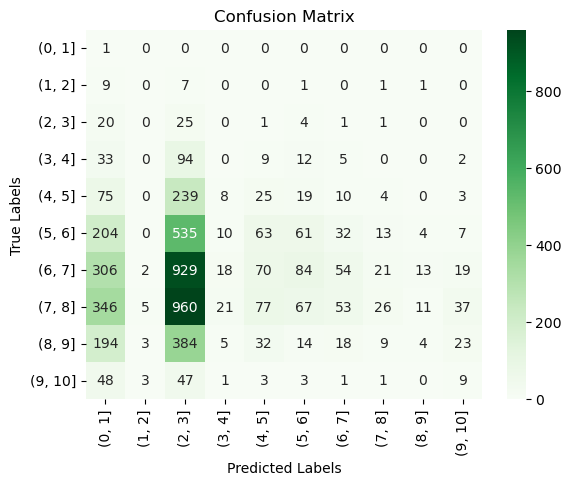

In [15]:
cm = confusion_matrix(y_test_gauss, y_pred_test)

# 7. Visualizzazione della Confusion Matrix

sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.savefig('gaussian_rating.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>CATEGORICAL NB</h2>

In [16]:

# 1. Selezioniamo le variabili numeriche
non_cat_columns = [
    "startYear", "runtimeMinutes", "awardWins", "totalImages", "totalVideos", 
    "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", 
    "userReviewsTotal", "ratingCount", "numRegions"
]

# Selezioniamo le feature numeriche dal training set
X_train_noncat = df_train[non_cat_columns].values

# 2. Codifica del target 'titleType' (etichetta categorica)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['rating'])  

# 3. Discretizzazione delle variabili numeriche nel training set
def discretize_column(X, num_categories=3):
    """Funzione per discretizzare una colonna in categorie numeriche"""
    X_cat = []
    
    for col_idx in range(X.shape[1]):
        # Verifica quante categorie uniche ci sono nella colonna
        unique_vals = np.unique(X[:, col_idx])
        # Riduci il numero di categorie se necessario
        n_categories = min(len(unique_vals), num_categories)
        # Discretizza la colonna in base al numero di categorie disponibili
        X_cat.append(pd.qcut(X[:, col_idx], q=n_categories, labels=False, duplicates='drop'))
    
    return np.array(X_cat).T

# Discretizza il set di addestramento
X_train_cat = discretize_column(X_train_noncat, num_categories=3)

# 4. Creazione del modello Naive Bayes categorico
nbc = CategoricalNB()
nbc.fit(X_train_cat, y_train)

# 5. Preparazione del Test Set

# Selezioniamo le stesse feature numeriche per il test set
X_test_noncat = df_test[non_cat_columns].values  # Usa df_test per il test set

# Discretizzazione del test set (stessa logica del training set)
X_test_cat = discretize_column(X_test_noncat, num_categories=3)  # Limita a 3 categorie

# Codifica anche le etichette del test set
y_test = label_encoder.transform(df_test['rating'])  # Codifica 'titleType' come nel training

# 6. Predizioni sul Test Set
y_pred_test = nbc.predict(X_test_cat)

# 7. Report di classificazione sul Test Set
print("Classification Report sul Test Set:")
print(classification_report(y_test, y_pred_test))

# 8. Calcolare ROC AUC (multi-class) sul test set
print("ROC AUC score sul Test Set:", roc_auc_score(y_test, nbc.predict_proba(X_test_cat), multi_class="ovr", average="micro"))



Classification Report sul Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        52
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00       383
           5       0.34      0.04      0.07       929
           6       0.32      0.48      0.38      1516
           7       0.36      0.62      0.45      1603
           8       0.18      0.07      0.10       686
           9       0.00      0.00      0.00       116

    accuracy                           0.33      5460
   macro avg       0.12      0.12      0.10      5460
weighted avg       0.27      0.33      0.26      5460

ROC AUC score sul Test Set: 0.8358281414691672


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


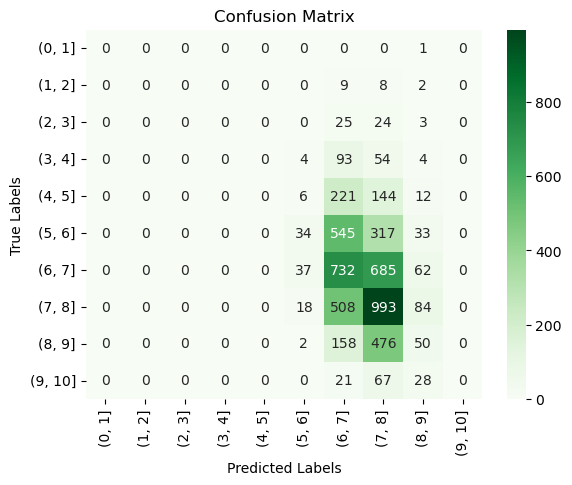

In [17]:
# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

# 10. Visualizzazione della Confusion Matrix

sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('categorical_rating.png', dpi=300, bbox_inches='tight')
plt.show()
